<a href="https://colab.research.google.com/github/clint-bg/demos/blob/main/shellandtube/ShellandTubePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shell and Tube Prediction
This sheet is designed to predict the response of a shell and tube heat exchanger given the following input
*   Flow rate through the tube side
*   Incoming temperature of the fluid (tube side)
*   Steam pressure on the shell side
*   Details of the heat exchanger (number of tubes, tube diameter, tube length etc.)

Predicted output will be:
*   Exit temperature of the fluid to be heated

The predicted output will be compared to the experimental result at multiple conditions to determine the effectiveness of the model.

--Clint Guymon, July 2022

## Heat Exchanger Details
The heat exchanger is a vertically oriented Standard Xchange shell and tube heat exchanger SSCF type and Model number 0314 (3 inch shell diameter and 14 inch tube length). Further details include the number of tubes (56) and the tube size (1/4" outside diameter and 24 BWG 0.022 inches). The baffle spacing on the shell side is either 1.5 or 4 inches depending on the exchanger.

The water flows through the tubes and the steam is on the shell side in contact with the external surface of the tubes.

![My Image](https://github.com/clint-bg/demos/blob/main/shellandtube/shellandtubesscf.png?raw=true)

## Governing Principles
Using empirical correlations for the shell and tube sides of the heat exchanger together with the heat exchanger details, we can estimate the heat imparted to the process fluid (water). From that heat amount and an energy balance, the temperature of the exiting fluid can be estimated. The governing equation for the heat transfer is based on the Log Mean Tempearture Difference (LMTD) approach and is:
$Q = U\cdot A\cdot F\cdot \Delta T_{LM}$

where $U$ is the overall heat transfer coefficient, $A$ is the area, $F$ is a LMTD correction factor based on the heat exchanger type (1 for condensing vapors), and $\Delta T_{LM}$ is the log-mean tempearture difference.  

The heat exchanged is also equal to the energy picked up by the fluid (water) after passing through the exchanger and is equivalent to:
$Q = \dot{m}\cdot C_p\cdot \Delta T$

where $\dot{m}$ is the mass flow, $C_p$ is the heat capacity, and $\Delta T$ is the change in temperature.

## Helpful resources
The NCEES Handbook for the chemical engineering exams is very helpful. It can be downloaded for free from the NCEES website after registering with them. See https://help.ncees.org/article/87-ncees-exam-reference-handbooks. Of course other resources can be used for the engineering principles, empirical correlations, and hueristics. The images with the equations and drawings here are directly from the NCEES Handbook for chemical engineering.

In [1]:
#import needed packages
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_theme()
from scipy.optimize import fsolve
from scipy import stats
import matplotlib.pyplot as plt

### Property data for water (SI Units)

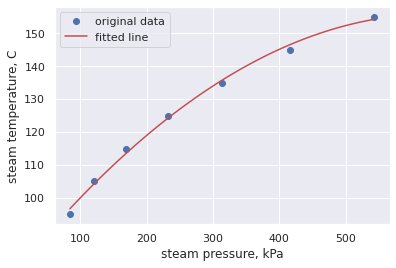

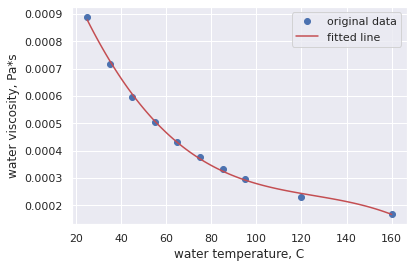

In [2]:
heatcapacity =  4182 #J/kg/K
thermalconductivity = 0.598 #W/m/K
density = 997 #kg/m3
heatofvaporization = 2.257E6 # J/kg
#steam temperature as a function of pressure given pressure in units of psig
steampressuredata = [84.55,120.82,169.06,232.1,313.0, 415.4,543.1] #kPa
steamtemperaturedata = [95,105,115,125,135,145,155] #degrees C
zsteam = np.polyfit(steampressuredata, steamtemperaturedata, 2)
plt.plot(steampressuredata, steamtemperaturedata, 'o', label='original data')
xlin = np.linspace(min(steampressuredata), max(steampressuredata), 100)
ylin = zsteam[2] + zsteam[1]*xlin + zsteam[0]*xlin**2
plt.plot(xlin, ylin, 'r', label='fitted line'); plt.xlabel("steam pressure, kPa"); plt.ylabel("steam temperature, C")
plt.legend(); plt.show()
def steamtemp(pressure=10): #returns C from psig
  kpapressurea = (pressure + 12.5)*6.895 #convert from gauge pressure in psi to absolute in kPa
  return zsteam[2] + zsteam[1]*kpapressurea + zsteam[0]*kpapressurea**2
#viscosity as a function of temperature
vtemperaturedata = [25,35,45,55,65,75,85,95,120,160]
viscositydata = [8.90E-4,7.19E-4,5.96E-4,5.04E-4,4.33E-4,3.78E-4,3.33E-4,2.97E-4,2.32E-4,1.70E-4]
zv = np.polyfit(vtemperaturedata, viscositydata, 3)
plt.plot(vtemperaturedata, viscositydata, 'o', label='original data')
xlin = np.linspace(min(vtemperaturedata), max(vtemperaturedata), 100)
ylin = zv[3] + zv[2]*xlin + zv[1]*xlin**2 + zv[0]*xlin**3
plt.plot(xlin, ylin, 'r', label='fitted line'); plt.xlabel("water temperature, C"); plt.ylabel("water viscosity, Pa*s")
plt.legend(); plt.show()
def viscosity(temperature=25): #returns C from psig
  return zv[3] + zv[2]*temperature + zv[1]*temperature**2 + zv[0]*temperature**3

Notice that in the definition of the above functions, a default is specified (10 for the pressure and 25 for the temperature in the steamtemp and viscosity functions, respectively). It's a good idea to always specify a default value. Also notice that the variable names are descriptive (they could even be more descriptive). Don't be lazy and name your variable with 2 or 3 letters. As the code gets more complex, no one (not even you) will want to work with your code.

### Properties of the heat exchanger


In [3]:
tubeod = 0.25*0.0254 #1/4 inches to meters
wallthickness = 0.022*0.0254 #24 BWG
wallthermalconductivity = 45 #W/m/K
tubeid = tubeod - wallthickness # m
numberoftubes = 56
tubelength = 14*0.0254 #m
tubebafflelength = 1.5*0.0254 #m
surfacearea = numberoftubes*np.pi*tubeod*tubelength # This is the total surface area of the tubes (outside)

## Approach and Initial Inputs
The approach in this writeup is to first give a **rough expected range** for the exit temperature based on some hueristics for the overall heat transfer coefficient. After that, the nitty-gritty correlations will be used to get a better estimate we'll call **the narrowed-in estimate**.

In [4]:
#define flow rate through the heat exchanger in gallons per minute (min)
flowgpmmin = 5; flowgpmmax = 50 #gallons per minute
#defline steam pressure (min)
steampressurepsigmin = 10; steampressurepsigmax = 50
#define inlet temperature
inlettempmin = 25; inlettempmax = 75 #C

In [5]:
def massflow(gpm=flowgpmmin):
  return gpm/264.2*density/60 #convert to SI units in kg/sec

### Rough Expected Range
This is a back-of-the-envelop estimate. There are engineering expected ranges for variables that can be effectively used to narrow in on the answer. Doing so can be very useful in understanding the problem and getting a feel for the outcome and expected results. It sometimes can be very easy to dive deeply into a problem and get lost with mistakes easily derailing your complex analysis. Doing a back-of-the-envelope estimate can help with that.

Equation to solve:      $\dot{m}\cdot C_p\cdot (T_{out}-T_{in}) = U\cdot A\cdot (T_{out} - T_{in})/ln((T_{cond}-T_{in})/(T_{cond}-T_{out}))$

![My Image](https://github.com/clint-bg/demos/blob/main/shellandtube/condensationlmtd.png?raw=true) 

The above figure is reproduced from the NCEES Handbook on Page 166 for shell and tube heat exchangers with condensation. 

#### Overall heat transfer coefficient Range
From the NCEES Handbook on Page 188, there's a table that is titled: Typical Overall Heat-Transfer Coefficients in Heaters (Shell and Tube) with Condensing Steam. In that table, for a heated fluid of water, the heat transfer coefficient is 1500-4000 W/m2/K. Based on that and a given condition (flow rate and the intial fluid temperature and the steam temperature/pressure) the exit temperature can be found.

In [6]:
overallUhueristic = [1500,4000]

In [7]:
#define equation to solve given the overall heat transfer coefficient
def func(x,*input):
  dct = input[0]
  Tcond = steamtemp(dct['pressure'])
  return dct['U']*surfacearea*(x-dct['inlettemp'])/np.log((Tcond-dct['inlettemp'])/(Tcond-x))-dct['massflow']*heatcapacity*(x-dct['inlettemp'])

#### Estimate is:

Generate curves based on the potential steam pressures and flow rates given the resultant change in temperature.

In [8]:
# Range of mass flows through the heat exchanger
gpmlin = np.linspace(flowgpmmin, flowgpmmax, 100)
#Range of steam pressures on the shell side
steamlin = [10,20,30,40]
#Range of inlet temperatures
inletlin = np.linspace(inlettempmin,inlettempmax,3)

In [9]:
#Solve for each combination of flow and steam pressure
#First build a dictionary that can easily be converted into a pandas dataframe (helpful for visualization and data processing)
modeleddata = {'temperature difference, C':[],'steam pressure, psig':[],'flow, gpm':[],'inlet temperature, C':[],'LMTD, C':[]} 
for steampr in steamlin:
  Tcond = steamtemp(steampr)
  for gpm in gpmlin:
    massf = massflow(gpm)
    for intemp in inletlin:
      input = {'U':overallUhueristic[1],'massflow':massf,'pressure':steampr,'inlettemp':intemp}
      outtemp = fsolve(func,intemp+5,args=(input))[0]; outtemp = outtemp if (outtemp<100) else 100; tmpdiff = outtemp - intemp;
      lmtd = tmpdiff/np.log((Tcond-intemp)/(Tcond-outtemp))
      modeleddata['temperature difference, C'].append(tmpdiff); modeleddata['steam pressure, psig'].append(steampr); 
      modeleddata['flow, gpm'].append(gpm); modeleddata['inlet temperature, C'].append(intemp); modeleddata['LMTD, C'].append(lmtd) 
df_maxhueristic = pd.DataFrame(modeleddata) #convert the dictionary to a dataframe    

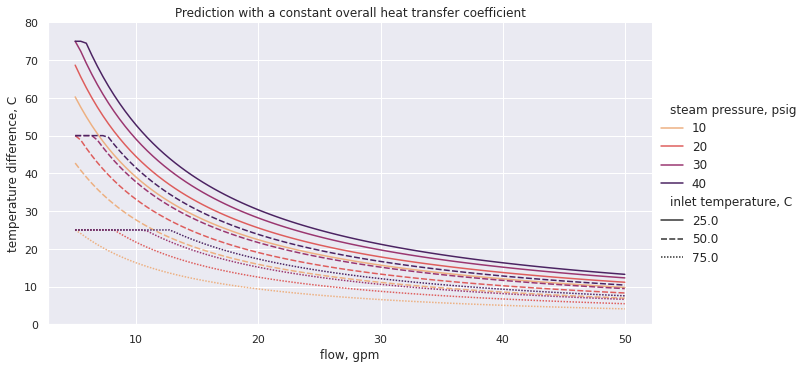

In [10]:
#now plot
p = sns.relplot(x='flow, gpm', y='temperature difference, C', hue='steam pressure, psig', kind="line", style='inlet temperature, C', palette='flare', data=df_maxhueristic, aspect=15/8);
p.axes[0,0].set_ylim(0,80);p.set(title='Prediction with a constant overall heat transfer coefficient')
plt.show()

Given a constant overall heat transfer coefficient, the above plot illustrates several points:
*  The temperature difference (outlet minus the inlet) decreases with increasing flow (expected as the residence time inside the heat exchanger is smaller with increasing flow) 
*  Increasing steam temperature yields a greater temperature difference as the shell side wall temperature is higher (higher temperature at higher steam pressures)
*  Increasing inlet temperatures results in a smaller temperature difference as the driving force for heat exchange is smaller

Why is the assumption of a constant overall heat transfer coefficient wrong?

### The Narrowed-In Estimate
Using the results from the Rough Expected Range estimate above, further analysis can be completed to get a better estimate. Those calculations are completed here. We'll first estimate the tube side and shell side heat transfer coefficients from empirical correlations.

#### Tube side heat transfer coefficient
Most correlations are functions of the Reynolds and Prandlt numbers so we'll calculate those first. The correlation for turbulent flow inside a circular pipe for the Nusselt number can be found on Page 150 of the NCEES Handbook and is below.

In [11]:
def surfacetemperature(steampressure=steampressurepsigmin): #estimate of the surface temperature of the tubes
  return steamtemp(steampressure) - 10

In [12]:
def internalh(gpm=flowgpmmin,noftubes=numberoftubes,tubeidi=tubeid,tubelengthi=tubelength,inlettemp=inlettempmin,steampr=steampressurepsigmin):
  avgtemp = inlettemp + 5
  massf = massflow(gpm)
  tubesurfacetemp = surfacetemperature(steampr)
  fluidvelocity = massf/density/(noftubes*np.pi/4*tubeid**2) #velocity of the fluid in m/s
  Re = density*tubeid*fluidvelocity/viscosity(avgtemp) #Reynolds number, with estimate of an average temperature of 5 degrees higher than the inlet
  Pr = heatcapacity*viscosity(avgtemp)/thermalconductivity
  if Re<2300: #Laminar flow
    insideNu = 1.86*((Re*Pr/(tubelengthi/tubeid))**0.33)*(viscosity(avgtemp)/viscosity(tubesurfacetemp))**0.14 #turbulent flow
  elif Re<10000:
    frictionfactor = 0.04
    insideNu = frictionfactor/8*Re*Pr**0.33
  else:
    insideNu = 0.023*(Re**0.8)*(Pr**0.33)*(viscosity(avgtemp)/viscosity(tubesurfacetemp))**0.14 #turbulent flow
  insideh = insideNu*thermalconductivity/tubeid  #W/m2/K
  return [insideh,Re,Pr]

In [87]:
internalh() #value at the default conditions

[1139.1189906336124, 1543.3408472567228, 5.594427122755699]

#### Shell side heat transfer coefficient
Condensing steam on a vertical surface, assumed laminar. The associated Nusselt number correlation is on Page 163 of the NCEES Handbook.

In [14]:
def externalh(bafflelength=tubebafflelength,steampr=steampressurepsigmin):
  tubesurfacetemp = surfacetemperature(steampr)
  outsideNu = 0.943*(((density**2)*9.81*heatofvaporization*bafflelength**3)/(viscosity(steamtemp(steampr))*thermalconductivity*(steamtemp(steampr)-tubesurfacetemp)))**0.25 
  outsideh = outsideNu*thermalconductivity/bafflelength
  return outsideh

In [15]:
externalh() #value at the default conditions

13947.110387760826

#### Overall heat transfer coefficient
The overall heat transfer coefficient is an inverse sum of the individual heat transfer coefficients including the thermal conductivity of the tube as given on Page 164 of the NCEES Handbook.

In [16]:
def Uov(hint=internalh()[0],tubeid=tubeid,tubeod=tubeod,hext=externalh(),RfiU=0):
  return 1/(1/hint*tubeod/tubeid + tubeod/2/wallthermalconductivity*np.log(tubeod/tubeid) + 1/hext + RfiU*tubeod/tubeid) #assuming no fouling
print(f'So the overall heat transfer coefficient, at the default conditions, without fouling, is {Uov():.0f} W/m2/K which is near the range from the hueristic quoted above')

So the overall heat transfer coefficient, at the default conditions, without fouling, is 961 W/m2/K which is near the range from the hueristic quoted above


##### Including Fouling
The NCEES handbook gives representative fouling factors in Section 4.4.1.5 on Page 190 which is partially reproduced below.

![My Image](https://github.com/clint-bg/demos/blob/main/shellandtube/foulingfactors.png?raw=true) 

In [17]:
Uovwithfouling = Uov(RfiU=0.0005) #assuming the shell side fouling is effectively zero (clean steam)
Uovwithfouling # W/m2/K at the default conditions

629.3176679401907

#### Estimate is:

In [18]:
#define a function to determine the outlet temperature as a function of the conditions
def predictedOutletTemp(gpmT=flowgpmmin,inlettempT=inlettempmin,steamprT=steampressurepsigmin,Rfi=0):
  hinte = internalh(gpm=gpmT,inlettemp=inlettempT,steampr=steamprT)[0] #The zero is for the first entry in the output array which is the heat transfer coefficient
  hexte = externalh(steampr=steamprT)
  U = Uov(hint=hinte,hext=hexte,RfiU=Rfi)
  input = {'U':U,'massflow':massflow(gpmT),'pressure':steamprT,'inlettemp':inlettempT}
  outtemp = fsolve(func,inlettempT+5,args=(input))[0]; 
  return outtemp

Note, anytime you're copying code or repeating the same thing, you're doing something wrong. Instead, define a function or object to complete the task once so that when you change a variable in that definition, you only need to do it once. Or in other words, make a function if you need the same line or lines of code more than once.

In [19]:
#Solve for each combination of flow and steam pressure
#First build a dictionary that can easily be converted into a pandas dataframe (helpful for visualization and data processing)
modelr = {'temperature difference, C':[],'steam pressure, psig':[],'flow, gpm':[],'inlet temperature, C':[],'LMTD, C':[]} 
for steampr in steamlin:
  Tcond = steamtemp(steampr)
  for gpm in gpmlin:
    massf = massflow(gpm)
    for intemp in inletlin:
      #first calculate the overall heat transfer coefficient for the condition
      outtemp = predictedOutletTemp(gpmT=gpm,inlettempT=intemp,steamprT=steampr,Rfi=0)
      tmpdiff = outtemp - intemp;
      lmtd = tmpdiff/np.log((Tcond-intemp)/(Tcond-outtemp))
      modelr['temperature difference, C'].append(tmpdiff); modelr['steam pressure, psig'].append(steampr); 
      modelr['flow, gpm'].append(gpm); modelr['inlet temperature, C'].append(intemp); modelr['LMTD, C'].append(lmtd) 
df = pd.DataFrame(modelr) #convert the dictionary to a dataframe  

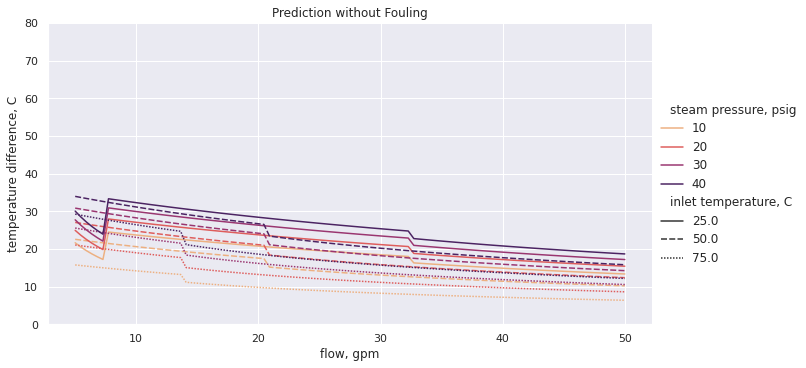

In [20]:
p = sns.relplot(x='flow, gpm',y='temperature difference, C',hue='steam pressure, psig',kind="line",style='inlet temperature, C',palette='flare',data=df,aspect=15/8);
p.axes[0,0].set_ylim(0,80); p.set(title='Prediction without Fouling')
plt.show()

Comparing the above plot with the overall heat transfer coefficient determined for each condition to the previous plot with a constant assumed overall heat transfer coefficient shows a reduction in the extremes: lower temperature difference at low flow and higher difference at high flow. This is expected because...what do you think?

### Surface Temperature Estimate:
The average surface temperature of the tubes can be estimated from the correlation in the NCEES Handbook on page 178 or methods published elsewhere. Here it is not calculated but is estimated at 10 degrees less than the steam temperature. Some references give a difference between the tube surface temperature and the steam temperature between 3 and 22 degrees.

# Experimental Data
Based on the results above (and the fact that the water recirculates, how could you design your experiment so the inlet temperature gradually increases?

Data was collected from the Shell and Tube heat exchanger at the Unit Operations Laboratory at Brigham Young University. A video of the apparatus is here: https://uolab.groups.et.byu.net/files/shelltube/videos/Shell%20&%20Tube.mp4. Data is given in the github repository and shown below in a pandas database. You'll see that the inlet temperature isn't constant as the water is recirculating.

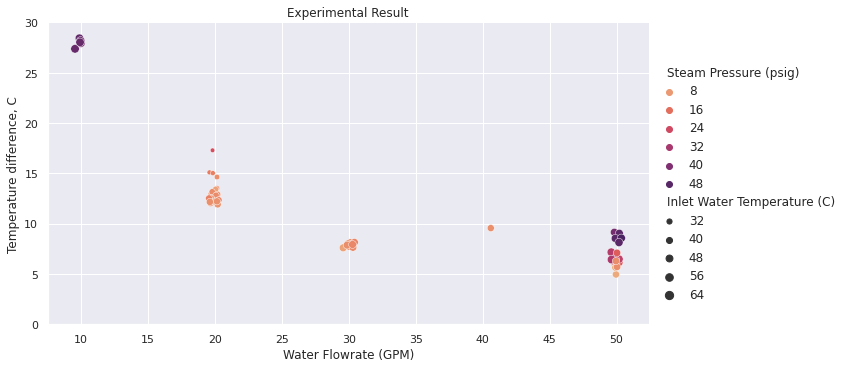

In [21]:
url = 'https://raw.githubusercontent.com/clint-bg/demos/main/shellandtube/July2022.csv' #url with raw data
data = pd.read_csv(url)
data['Temperature difference, C'] = data['Outlet Water Temperature (C)'] - data['Inlet Water Temperature (C)']
e = sns.relplot(x='Water Flowrate (GPM)',y='Temperature difference, C',hue='Steam Pressure (psig)',size='Inlet Water Temperature (C)', data=data,palette='flare',aspect=15/8)
e.axes[0,0].set_ylim(0,30); e.set(title='Experimental Result')
plt.show()

The above plot shows a similar trend as that observed with the model in that:
*  higher inlet temperatures result in a lower temperature change
*  higher flow also results in a lower temperature change
*  increased steam pressure yields a higher temperature difference

# Comparison between the Model Prediction and the Experiment

In [82]:
#First setup the new dataframe from the existing one with the needed conditions
modelpredict = pd.DataFrame()
modelpredict = data['Steam Pressure (psig)'].copy().to_frame()
modelpredict['Water Flowrate (GPM)'] = data['Water Flowrate (GPM)'].copy()
modelpredict['Inlet Water Temperature (C)'] = data['Inlet Water Temperature (C)'].copy()
data['Source'] = 'experiment'; modelpredict['Source'] = 'model'
#For each of the experimental conditions, calculate the model result (without fouling) and then compare the residuals
predictedarray = []
for i,row in modelpredict.iterrows():
  predictedarray.append(predictedOutletTemp(gpmT=modelpredict['Water Flowrate (GPM)'][i],inlettempT=modelpredict['Inlet Water Temperature (C)'][i],steamprT=modelpredict['Steam Pressure (psig)'][i],Rfi=0.0001))
modelpredict['Outlet Water Temperature (C)'] = predictedarray
modelpredict['Temperature difference, C'] = modelpredict['Outlet Water Temperature (C)'] - modelpredict['Inlet Water Temperature (C)']
#modelpredict.assign(ModelPrediction = lambda modelpredict: predictedOutletTemp(gpm=modelpredict['Water Flowrate (GPM)'],inlettemp=modelpredict['Inlet Water Temperature (C)'],steampr=modelpredict['Steam Pressure (psig)'],Rfi=0))
#concatentate the two dataframes
dfall = pd.concat([data,modelpredict])

Note, although it may be easier to just create a new column in the dataframe called "Predicted Outlet Temperature" that corresponds to the other conditions in the experimental dataframe, that won't workout as well as far as ease of visualization. A better way (although more repetative) is to concatenate another table with the modeled result as done above.

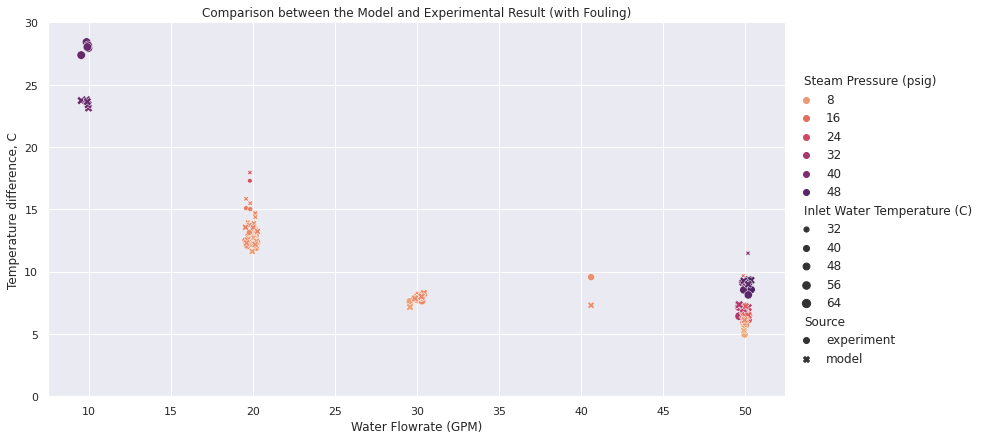

In [88]:
a = sns.relplot(x='Water Flowrate (GPM)',y='Temperature difference, C',hue='Steam Pressure (psig)',size='Inlet Water Temperature (C)', style='Source', data=dfall,palette='flare',aspect=15/8,height=6)
a.axes[0,0].set_ylim(0,30); a.set(title='Comparison between the Model and Experimental Result (with Fouling)')
plt.show()

The agreement looks to be very good between the model (x) and the experiment (o) except when the flow was near 10 gpm and the inlet water temperature was high with a high steam pressure. Why? Perhaps boiling of the fluid began. A quantified measure of agreement between the experimental and model results is below.

## Measure of Agreement:
The residuals between the experimental results and those of the model can be plotted. Additionally, an $R^2$ or coefficient of determination value can be found. There are other methods to estimate the goodness of fit (like what?).

The R^2 value is 0.94


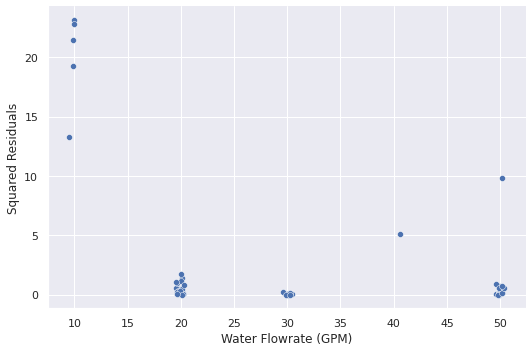

In [90]:
modelpredict['Squared Residuals'] = (data['Temperature difference, C'] - modelpredict['Temperature difference, C'])**2
sns.relplot(x='Water Flowrate (GPM)',y='Squared Residuals',data=modelpredict,aspect=15/10)
se = (modelpredict['Temperature difference, C'] - data['Temperature difference, C'])**2
ssa = (data['Temperature difference, C'] - data['Temperature difference, C'].mean())**2
rsquared = 1-se.sum()/ssa.sum()
print(f'The R^2 value is {rsquared:.2f}')

# Summary
The residuals and the R-squared value show that the model termed "The Narrowed-In Estimate" does a great job of predicting the outlet temperature of the given size of the shell and tube heat exchanger when given the inlet temperature, the steam pressure, and the flow rate. When the outlet temperature is very near the boiling point, the model underpredicts the outlet temperature, presumably because the heat transfer rate increases with bubble formation.

The Rough model where the overall heat transfer coefficient is estimated to be between 1500-4000 W/m2/K can give a good initial estimate of expected results for moderate Reynolds numbers (between 5E3 and 1E4) when the expected outlet temperature is not near the boiling point.

# Follow-up Questions
*  How would you expect the overall heat transfer coefficient to change with a different sized heat exchanger? How would you get a good estimate of that overall heat transfer coefficient?  
*  Is it possible to flood the shell side of the heat exchanger? What would that result in?
*  What other model results could you predict given the experimental setup? (The incoming and exit fluid flow and temperature are known or could be found)
*  Which parameters in the model defining the heat transfer coefficients are the most important? The tube-sdie heat transfer coefficient? Or is it the shell-side? Or is it a function of the conditions? 
